# KLSE Pipelines

## Common imports and functions

In [305]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import datetime as dt
import calendar as cal
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

### Pipeline imports

In [306]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
import numpy.core.defchararray as npf

### DataFrame selector class

In [307]:
# DataFrame selector
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

### Data Preprocessor

In [308]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        # Derive dividend year
        X['dividend_year'] = pd.to_datetime(X['ex_dividend_date'], format='%b %d, %Y').dt.year
        
        # Convert yield to float
        X['yield'] = X['yield'].replace('-','0')
        X['yield'] = X['yield'].str.rstrip('%').astype('float')
        
        # Get a unique code id
        X['code_id'] = df_dividends.groupby('code').ngroup()
        
        # Sum the yield by dividend year
        # X = X.groupby(['code_id','dividend_year']).agg({'dividend': np.sum, 'yield': np.sum})
        X = X.groupby(['code_id','dividend_year']).agg({'yield': np.sum})
        X = X.reset_index()
        # print(X)
        X = X.drop(['dividend_year'], axis=1)   # Drop the year now so only categorize based on the 
        return X
        # return X.drop(['ex_dividend_date','payment_date', 'code', 'name'], axis=1)   # Drop non numerical columns

### Processing pipelines

In [309]:
df_dividends = pd.read_csv('../dataset/KLSE_dividends_investing.csv')
df_dividends.info()
df_dividends.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2315 entries, 0 to 2314
Data columns (total 6 columns):
code                2315 non-null object
name                2315 non-null object
ex_dividend_date    2315 non-null object
dividend            2315 non-null float64
payment_date        2315 non-null object
yield               2315 non-null object
dtypes: float64(1), object(5)
memory usage: 108.6+ KB


,code,name,ex_dividend_date,dividend,payment_date,yield
0,5218,Sapura Energy Bhd (SAEN),"Apr 12, 2017",0.0100,"Apr 28, 2017",2.94%
1,5218,Sapura Energy Bhd (SAEN),"Jul 29, 2015",0.0135,"Aug 28, 2015",0.72%
2,138,MY EG Services Bhd (MYEG),"Apr 24, 2018",0.0170,"May 25, 2018",1.30%
3,138,MY EG Services Bhd (MYEG),"Jan 04, 2018",0.0170,"Feb 06, 2018",0.63%
4,138,MY EG Services Bhd (MYEG),"Apr 21, 2017",0.0137,"May 24, 2017",0.64%
5,138,MY EG Services Bhd (MYEG),"Dec 23, 2016",0.0120,"Jan 25, 2017",0.74%
6,138,MY EG Services Bhd (MYEG),"Apr 22, 2016",0.0120,"May 24, 2016",0.56%
7,138,MY EG Services Bhd (MYEG),"Jan 04, 2016",0.0095,"Feb 04, 2016",0.44%
8,128,Frontken Corporation Bhd (FRKN),"Sep 15, 2017",0.0050,"Oct 04, 2017",0.60%
9,9385,Lay Hong Bhd (LAYH),"Oct 18, 2018",0.0050,"Nov 15, 2018",0.79%


### Remove those without dividends in previous year

In [310]:
# Get previous year
prev_year = dt.datetime.now().year - 1

## Remove those without dividend in previous year
df = df_dividends.copy()
df['dividend_year'] = pd.to_datetime(df['ex_dividend_date'], format='%b %d, %Y').dt.year
df = df[df['dividend_year'] == prev_year]

df_dividends = df_dividends[df_dividends.code.isin(df['code'].unique())]

## Only take last 3 years including this year
df_dividends = df_dividends[pd.to_datetime(df_dividends['ex_dividend_date'], format='%b %d, %Y').dt.year >= (prev_year - 1) ]

df_dividends.info()
df_dividends.head(30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1785 entries, 0 to 2310
Data columns (total 6 columns):
code                1785 non-null object
name                1785 non-null object
ex_dividend_date    1785 non-null object
dividend            1785 non-null float64
payment_date        1785 non-null object
yield               1785 non-null object
dtypes: float64(1), object(5)
memory usage: 97.6+ KB


,code,name,ex_dividend_date,dividend,payment_date,yield
0,5218,Sapura Energy Bhd (SAEN),"Apr 12, 2017",0.0100,"Apr 28, 2017",2.94%
2,138,MY EG Services Bhd (MYEG),"Apr 24, 2018",0.0170,"May 25, 2018",1.30%
3,138,MY EG Services Bhd (MYEG),"Jan 04, 2018",0.0170,"Feb 06, 2018",0.63%
4,138,MY EG Services Bhd (MYEG),"Apr 21, 2017",0.0137,"May 24, 2017",0.64%
5,138,MY EG Services Bhd (MYEG),"Dec 23, 2016",0.0120,"Jan 25, 2017",0.74%
6,138,MY EG Services Bhd (MYEG),"Apr 22, 2016",0.0120,"May 24, 2016",0.56%
7,138,MY EG Services Bhd (MYEG),"Jan 04, 2016",0.0095,"Feb 04, 2016",0.44%
8,128,Frontken Corporation Bhd (FRKN),"Sep 15, 2017",0.0050,"Oct 04, 2017",0.60%
9,9385,Lay Hong Bhd (LAYH),"Oct 18, 2018",0.0050,"Nov 15, 2018",0.79%
10,9385,Lay Hong Bhd (LAYH),"Oct 13, 2017",0.0050,"Nov 08, 2017",0.57%


In [311]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from future_encoders import OneHotEncoder
from sklearn.pipeline import FeatureUnion

standard_attribs = list(df_dividends)
code_attrib = ["code"]

standard_pipeline = Pipeline([
        ('selector', DataFrameSelector(standard_attribs)),
        ('preprocessor', DataPreprocessor()),
        ('scaler', StandardScaler()),
    ])

#code_pipeline = Pipeline([
#       ('selector', DataFrameSelector(code_attrib)),
#       ('code_encoder', OneHotEncoder(sparse=False))
#    ])



full_pipeline = FeatureUnion(transformer_list=[
        ("standard_attribs", standard_pipeline),
        #("code_attrib", code_pipeline)
    ])

df_prepared = full_pipeline.fit_transform(df_dividends)
df_prepared

array([[-1.74512782, -0.33168822],
       [-1.74512782,  1.29219618],
       [-1.74512782,  0.29205546],
       ...,
       [ 1.73640367,  1.17389997],
       [ 1.74392318,  0.87708401],
       [ 1.74392318, -0.33814074]])

### Categorize the stocks

1470.1704671292164


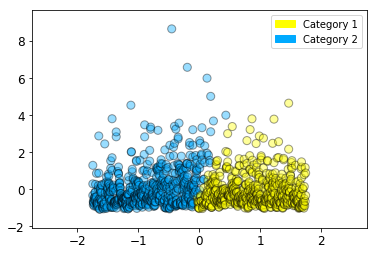

805.6021506893994


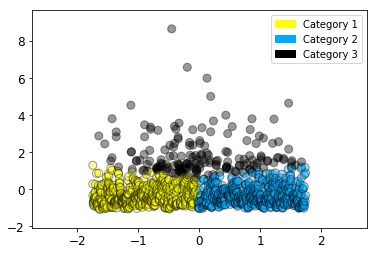

637.9933604421383


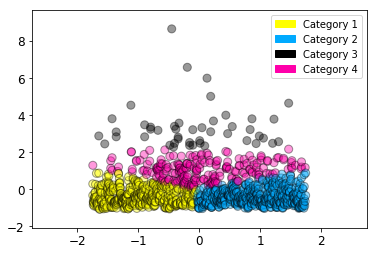

521.3106037421004


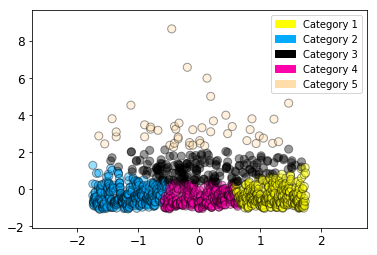

418.31949504015824


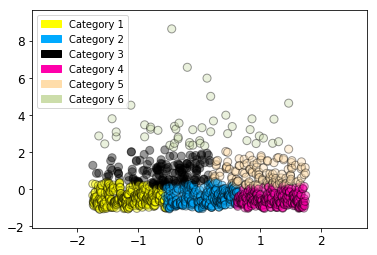

367.8716049197526


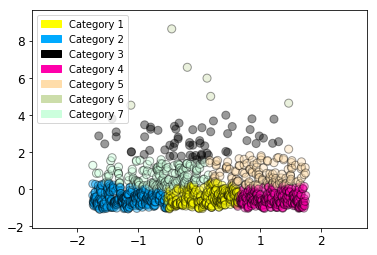

326.7279434161784


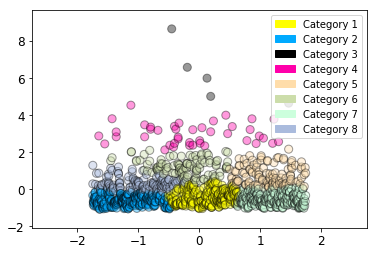

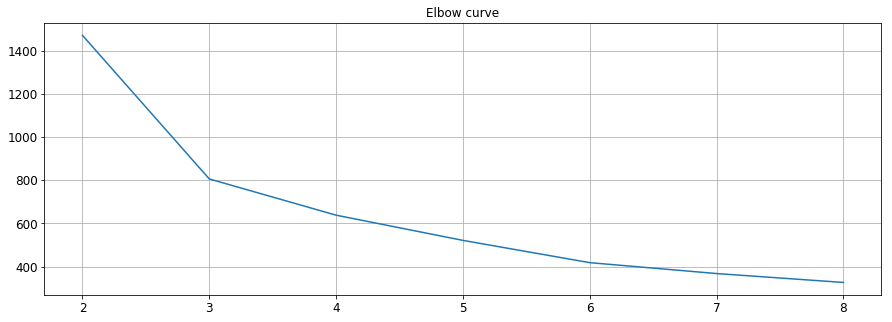

In [312]:
from sklearn.cluster import KMeans
from adspy_shared_utilities import plot_labelled_scatter
from sklearn import metrics
from scipy.spatial.distance import cdist

# print([ "Category " + str(i) for i in list(range(1,3)) ] )
      
distortions = []
for k in range(2,9):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_prepared)
    print(kmeans.inertia_)
    distortions.append(kmeans.inertia_)
    plot_labelled_scatter(df_prepared, kmeans.labels_, 
                          [ "Category " + str(i) for i in list(range(1,k+1)) ] )

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 9), distortions)
plt.grid(True)
plt.title('Elbow curve')

### From the elbow curve, the number of clusters = 3. Build the full pipeline

805.6139255890953


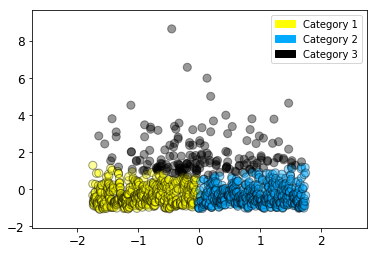

[[-1.74512782 -0.33168822]
 [-1.74512782  1.29219618]
 [-1.74512782  0.29205546]
 ...
 [ 1.73640367  1.17389997]
 [ 1.74392318  0.87708401]
 [ 1.74392318 -0.33814074]]


In [313]:
df_prepared = full_pipeline.fit_transform(df_dividends)
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_prepared)
print(kmeans.inertia_)
plot_labelled_scatter(df_prepared, kmeans.labels_, 
                      [ "Category " + str(i) for i in list(range(1,4)) ] )

print(df_prepared)

### Show the stocks clusters

In [314]:
# print(df_dividends)
data_preprocessor = DataPreprocessor()
df_preprocessed = data_preprocessor.fit_transform(df_dividends.copy())   ## Create a new copy
# standard_scaler = StandardScaler()
# df_normalized = standard_scaler.fit_transform(df_preprocessed)
# df_normalized.shape

df_preprocessed['category'] = kmeans.labels_
# df_preprocessed['code_id'].unique()
# print(df_preprocessed.shape)
# print(kmeans.labels_.shape)
df_preprocessed.head(10)

,code_id,yield,category
0,0,3.63,0
1,0,11.18,0
2,0,6.53,0
3,1,1.27,0
4,1,2.02,0
5,2,2.27,0
6,2,1.82,0
7,2,1.67,0
8,3,0.95,0
9,3,2.71,0


In [315]:
df_lookup = df_dividends.copy()
df_lookup['dividend_year'] = pd.to_datetime(df_lookup['ex_dividend_date'], format='%b %d, %Y').dt.year
df_lookup['yield'] = df_lookup['yield'].replace('-','0')
df_lookup['yield'] = df_lookup['yield'].str.rstrip('%').astype('float')
df_lookup['code_id'] = df_lookup.groupby('code').ngroup()       
df_lookup = df_lookup.groupby(['code_id','dividend_year','code','name']).agg({'yield': np.sum})
df_lookup = df_lookup.reset_index()
df_lookup.head(10)

,code_id,dividend_year,code,name,yield
0,0,2016,0011,Brite Tech Bhd (BECH),3.63
1,0,2017,0011,Brite Tech Bhd (BECH),11.18
2,0,2018,0011,Brite Tech Bhd (BECH),6.53
3,1,2016,0012,Three A Resources Bhd (THEA),1.27
4,1,2017,0012,Three A Resources Bhd (THEA),2.02
5,2,2016,0023,IFCA MSC Bhd (IFCA),2.27
6,2,2017,0023,IFCA MSC Bhd (IFCA),1.82
7,2,2018,0023,IFCA MSC Bhd (IFCA),1.67
8,3,2017,0024,JAG Bhd (JAGB),0.95
9,3,2018,0024,JAG Bhd (JAGB),2.71


### Join df_dividends with df_preprocessed

In [316]:
df_categorized = pd.merge(df_preprocessed, df_lookup, how='left', left_on=['code_id','yield'], right_on=['code_id', 'yield'])

In [317]:
# df_categorized.head(1000)

# df_dividends[df_dividends['code'] == '0011'].head(20)
df_categorized[df_categorized['category'] == 2].head(10)

,code_id,yield,category,dividend_year,code,name
31,13,18.56,2,2017,0099,Scicom MSC Bhd (SCCM)
62,26,16.56,2,2017,0158,SCC Holdings Bhd (SCCH)
92,39,12.31,2,2016,1155,Malayan Banking Bhd (MBBM)
101,42,13.09,2,2016,1198,MAA Group Bhd (MAAS)
102,42,22.88,2,2017,1198,MAA Group Bhd (MAAS)
123,51,18.35,2,2017,1562,Berjaya Sports Toto Bhd (BSTB)
124,51,19.57,2,2018,1562,Berjaya Sports Toto Bhd (BSTB)
136,56,10.76,2,2016,1724,Paramount Corporation Bhd (PRMS)
208,83,26.28,2,2017,2674,Aluminium Company of Malaysia Bhd (ALCO)
209,84,14.53,2,2017,2771,Boustead Holdings Bhd (BOUS)


### For each stocks under each category validate and analyse them

In [319]:
from IPython.display import display
pd.options.display.max_columns = 50

for c in range(2, -1, -1):
    df_category = df_categorized[df_categorized['category'] == c]
    # display(df_category.describe(include=[np.number]).T)
    # display(df_category.nlargest(30, 'yield'))
    df_high_yields = df_category.groupby(['code_id','code','name'])['yield'].agg(['sum','mean'])
    level0 = df_high_yields.columns.get_level_values(0)
    df_high_yields.columns = 'yield_' + level0
    df_high_yields.reset_index(inplace=True)
    df_high_yields.set_index('code_id', inplace=True)
    df_high_yields.sort_values(by=['yield_sum', 'yield_mean'], ascending=False, inplace=True)
    print('\n\nCategory {}'.format(c))
    display(df_high_yields.nlargest(60, 'yield_sum'))
    df_high_yields.to_csv('../dataset/KLSE_category_{}.csv'.format(c), encoding='utf-8', index=False, float_format='%g')




Category 2


,code,name,yield_sum,yield_mean
code_id,,,,
218,5191,Tambun Indah Land Bhd (TAMB),49.69,16.563333
257,5272,Ranhill Holdings Ltd (RANH),48.11,24.055000
206,5161,JCY International Bhd (JCYI),47.34,23.670000
249,5254,Boustead Plantations Bhd (BOPL),47.29,23.645000
294,6084,Star Media Group Bhd (STAR),45.65,15.216667
172,5078,Marine & General Bhd (MARI),45.45,45.450000
427,8524,Taliworks Corporation Bhd (TWRK),42.03,21.015000
126,4502,Media Prima Bhd (MPRM),41.03,20.515000
142,5010,Tong Herr Resources Bhd (THRB),40.67,13.556667




Category 1


,code,name,yield_sum,yield_mean
code_id,,,,
386,7210,Freight Management Holdings (FMHB),25.05,8.350000
431,8621,LPI Capital Bhd (LOND),24.66,8.220000
379,7200,Tek Seng Holdings Bhd (TSHB),22.34,7.446667
393,7233,Dufu Tech Corp Bhd (DUFU),21.69,7.230000
362,7149,Eng Kah Corporation Bhd (ENGH),21.18,7.060000
242,5246,Westports Holdings Bhd (WPHB),20.89,6.963333
412,7668,Hai O Enterprise Bhd (HAIO),20.82,6.940000
266,5371,Kim Hin Industry Bhd (KIMH),20.07,6.690000
274,5592,Grand Central Enterprises Bhd (GRAN),19.45,3.890000




Category 0


,code,name,yield_sum,yield_mean
code_id,,,,
16,0105,Asia Poly Holdings Bhd (ASPY),24.04,4.808000
88,2879,Chemical Company of Malaysia (CLMS),21.87,7.290000
35,1023,Bumiputra - Commerce Holdings Bhd (CIMB),21.60,7.200000
0,0011,Brite Tech Bhd (BECH),21.34,7.113333
58,1818,Bursa Malaysia Bhd (BMYS),21.30,7.100000
166,5066,NTPM Holdings Bhd (NTPM),20.13,6.710000
132,4863,Telekom Malaysia Bhd (TLMM),20.13,6.710000
225,5211,Sunway Bhd (SWAY),19.99,6.663333
153,5027,Kim Loong Resources Bhd (KIML),19.78,6.593333
